In [3]:
from tensorflow.python.keras.layers import deserialize
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt
import time
import yaml
import skimage.measure
print('tensorflow version',tf.__version__)

tensorflow version 2.1.0


In [4]:
#Using GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
#config = tf.compat.v1.ConfigProto(gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.3))
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)

In [5]:
bin_size   = 4 #In this model, the data is already binned to size 5k from original spectra of size 25k. This is additional binning.
input_size= 5121//bin_size + 1 
num_output= input_size 
num_class = 4

pos_enc  = True

In [6]:
start_time=time.time()
labels    = np.load('./../binned_data/binned_labels_100k.npy') #shape=(examples,labels of each spectra=5121)
end_time=time.time()
print('Time taken for loading mode data= %f s'%(end_time-start_time))

print('loaded mode data and its shape is (%d,%d)'%(labels.shape[0],labels.shape[1]))

labels = skimage.measure.block_reduce(labels,block_size=(1,bin_size),func=np.min)
labels = labels.astype(np.int32)

print('Binned label data and its shape is (%d,%d)'%(labels.shape[0],labels.shape[1]))

Time taken for loading mode data= 0.935817 s
loaded mode data and its shape is (100000,5121)
Binned label data and its shape is (100000,1281)


In [7]:
start_time=time.time()
spectrum_data = np.load('./../binned_data/binned_data_100k.npy') #shape=(examples,length of spectrum)
end_time=time.time()
print('Time taken for loading spectrum data= %f s'%(end_time-start_time))

print('loaded spectrum data and its shape is (%d,%d)'%(spectrum_data.shape[0],spectrum_data.shape[1]))

spectrum_data = skimage.measure.block_reduce(spectrum_data,block_size=(1,bin_size),func=np.mean)
spectrum_data = spectrum_data.reshape(spectrum_data.shape[0],spectrum_data.shape[1],1)

print('Binned spectra data and its shape is (%d,%d,1)'%(spectrum_data.shape[0],spectrum_data.shape[1]))

Time taken for loading spectrum data= 0.831377 s
loaded spectrum data and its shape is (100000,5121)
Binned spectra data and its shape is (100000,1281,1)


In [8]:
def positional_enc(X):

    X=np.squeeze(X)
    X = 2.*X
    X = X-1.
    pos_enc_sin = np.sin(np.arange(X.shape[1]))
    pos_enc_cos = np.cos(np.arange(X.shape[1]))


    X_pos    = np.empty((X.shape[0],X.shape[1],2),dtype=np.float32)
    X_pos[:,:,0] = X + pos_enc_sin
    X_pos[:,:,1] = X + pos_enc_sin

    return X_pos



if pos_enc ==True:
    spectrum_data = positional_enc(spectrum_data)    

#### Loading Model and the weights

In [9]:
#Path to the model
path = './../models/cnn_model_classification__lay_6__ksize_5__psize_3__dilrate_1__dropout_2__0.25__binsize__20__epochs_10__bs_128__train_28k__val_2k___generator_inp_size_1281_test_pos_enc_t'
yaml_file = open('%s/model.yaml'%path, 'r') #Loading model from yaml file 
loaded_model_yaml = yaml_file.read()
yaml_file.close()
config = yaml.load(loaded_model_yaml,Loader=yaml.UnsafeLoader)
model = deserialize(config)
model.load_weights("%s/model.h5"%path) #Loading weights (either model.h5 or checkpoint-(num_epoch)-(val_loss).hdf5)
print("Loaded model from disk")

Loaded model from disk


In [10]:
example = 2 #example to visualise or predict the labels
#predicted probability array of all outputs
pred_prob = model.predict(spectrum_data[example,:].reshape(1,spectrum_data.shape[1],spectrum_data.shape[2]))
pred_prob = np.squeeze(np.array(pred_prob))
predictied_labels = np.argmax(pred_prob,axis=1)

(array([-0.5,  0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5]),
 <a list of 9 Text major ticklabel objects>)

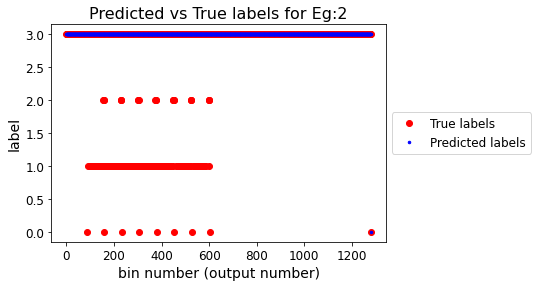

In [11]:
plt.plot(labels[example,:],'ro',label='True labels',ms=6)
plt.plot(predictied_labels,'bo',label='Predicted labels',ms=2.5)
plt.title('Predicted vs True labels for Eg:%d'%example,fontsize=16)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),fontsize=12)
plt.xlabel('bin number (output number)',fontsize=14)
plt.ylabel('label',fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)